# EfficientDet Tutorial: inference, eval, and training 



<table align="left"><td>
  <a target="_blank"  href="https://github.com/google/automl/blob/master/efficientdet/tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on github
  </a>
</td><td>
  <a target="_blank"  href="https://colab.sandbox.google.com/github/google/automl/blob/master/efficientdet/tutorial.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td></table>

# 0. Install and view graph.

## 0.1 Install package and download source code/image.



In [1]:
%%capture
#@title
import os
import sys
import tensorflow.compat.v1 as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

# Download source code.
if "efficientdet" not in os.getcwd():
  !git clone --depth 1 https://github.com/google/automl
  os.chdir('automl/efficientdet')
  sys.path.append('.')
  !pip install -r requirements.txt
  !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
else:
  !git pull

In [2]:
MODEL = 'efficientdet-d0'  #@param

def download(m):
  if m not in os.listdir():
    !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{m}.tar.gz
    !tar zxf {m}.tar.gz
  ckpt_path = os.path.join(os.getcwd(), m)
  return ckpt_path

# Download checkpoint.
ckpt_path = download(MODEL)
print('Use model in {}'.format(ckpt_path))

# Prepare image and visualization settings.
image_url =  'https://user-images.githubusercontent.com/11736571/77320690-099af300-6d37-11ea-9d86-24f14dc2d540.png'#@param
image_name = 'img.png' #@param
!wget {image_url} -O img.png
import os
img_path = os.path.join(os.getcwd(), 'img.png')

min_score_thresh = 0.35  #@param
max_boxes_to_draw = 200  #@param
line_thickness =   2#@param

import PIL
# Get the largest of height/width and round to 128.
image_size = max(PIL.Image.open(img_path).size)

Use model in /shared/anastasio-s1/Cellcounting/wb_cells/cell_detection/efficientdet/efficientdet-d0
--2021-02-26 00:35:23--  https://user-images.githubusercontent.com/11736571/77320690-099af300-6d37-11ea-9d86-24f14dc2d540.png
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4080549 (3.9M) [image/png]
Saving to: ‘img.png’

100%[======================================>] 4,080,549   --.-K/s   in 0.1s    

2021-02-26 00:35:24 (35.1 MB/s) - ‘img.png’ saved [4080549/4080549]



## 0.2 View graph in TensorBoard

In [3]:
!python model_inspect.py --model_name={MODEL} --logdir=logs &> /dev/null
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 32230), started 16:27:29 ago. (Use '!kill 32230' to kill it.)

# 1. inference

## 1.1 Benchmark network latency
There are two types of latency:
network latency and end-to-end latency.

*   network latency: from the first conv op to the network class and box prediction.
*   end-to-end latency: from image preprocessing, network, to the final postprocessing to generate a annotated new image.


In [4]:
# benchmaak network latency
!python model_inspect.py --runmode=bm --model_name=efficientdet-d4 --hparams="mixed_precision=true"

# With colab + Tesla T4 GPU, here are the batch size 1 latency summary:
# D0 (AP=33.5):  14.9ms,  FPS = 67.2   (batch size 8 FPS=)
# D1 (AP=39.6):  22.7ms,  FPS = 44.1   (batch size 8 FPS=)
# D2 (AP=43.0):  27.9ms,  FPS = 35.8   (batch size 8 FPS=)
# D3 (AP=45.8):  48.1ms,  FPS = 20.8   (batch size 8 FPS=)
# D4 (AP=49.4):  81.9ms,  FPS = 12.2   (batch size 8 FPS=)

2021-02-26 00:36:30.094215: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-02-26 00:36:37.346903: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-02-26 00:36:37.347820: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-02-26 00:36:37.349357: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-02-26 00:36:37.387318: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: TITAN X (Pascal) computeCapability: 6.1
coreClock: 1.531GHz coreCount: 28 deviceMemorySi

Start benchmark runs total=10
Per batch inference time:  0.9750890526920557
FPS:  1.025547356150876


## 1.2 Benchmark end-to-end latency

In [5]:
# Benchmark end-to-end latency (: preprocess + network + posprocess).
#
# With colab + Tesla T4 GPU, here are the batch size 1 latency summary:
# D0 (AP=33.5): 22.7ms,  FPS = 43.1   (batch size 4, FPS=)
# D1 (AP=39.6): 34.3ms,  FPS = 29.2   (batch size 4, FPS=)
# D2 (AP=43.0): 42.5ms,  FPS = 23.5   (batch size 4, FPS=)
# D3 (AP=45.8): 64.8ms,  FPS = 15.4   (batch size 4, FPS=)
# D4 (AP=49.4): 93.7ms,  FPS = 10.7   (batch size 4, FPS=)

m = 'efficientdet-d4'  # @param
batch_size = 1  # @param
m_path = download(m)

saved_model_dir = 'savedmodel'
!rm -rf {saved_model_dir}
!python model_inspect.py --runmode=saved_model --model_name={m} \
  --ckpt_path={m_path} --saved_model_dir={saved_model_dir} \
  --batch_size={batch_size}  --hparams="mixed_precision=true"
!python model_inspect.py --runmode=saved_model_benchmark --model_name={m} \
  --ckpt_path={m_path} --saved_model_dir={saved_model_dir}/{m}_frozen.pb \
  --batch_size={batch_size}  --hparams="mixed_precision=true" --input_image=testdata/img1.jpg


2021-02-26 00:37:12.162662: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-02-26 00:37:18.646313: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-02-26 00:37:18.646927: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-02-26 00:37:18.648545: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-02-26 00:37:18.695788: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: TITAN X (Pascal) computeCapability: 6.1
coreClock: 1.531GHz coreCount: 28 deviceMemorySi

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W0226 00:38:16.313242 139828941764416 deprecation.py:339] From /shared/anastasio-s1/Cellcounting/wb_cells/cell_detection/efficientdet/inference.py:558: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
W0226 00:38:16.313519 139828941764416 deprecation.py:339] From /home/sh38/anaconda3/envs/tf_effdet/lib/python3.6/site-packages/tensorflow/python/framework/convert_to_constants.py:856: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2021-02-26 00:38:22.563858: I tensorflow/stream_executor/platform/default/dso

## 1.3 Inference images.

---



In [6]:
# first export a saved model.
saved_model_dir = 'savedmodel'
!rm -rf {saved_model_dir}
!python model_inspect.py --runmode=saved_model --model_name={MODEL} \
  --ckpt_path={ckpt_path} --saved_model_dir={saved_model_dir}

# Then run saved_model_infer to do inference.
# Notably: batch_size, image_size must be the same as when it is exported.
serve_image_out = 'serve_image_out'
!mkdir {serve_image_out}

!python model_inspect.py --runmode=saved_model_infer \
  --saved_model_dir={saved_model_dir} \
  --model_name={MODEL}  --input_image=testdata/img1.jpg  \
  --output_image_dir={serve_image_out} \
  --min_score_thresh={min_score_thresh}  --max_boxes_to_draw={max_boxes_to_draw}

2021-02-25 15:44:06.704952: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-02-25 15:44:14.657691: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-02-25 15:44:14.658331: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-02-25 15:44:14.660112: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-02-25 15:44:14.698501: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: TITAN X (Pascal) computeCapability: 6.1
coreClock: 1.531GHz coreCount: 28 deviceMemorySi

mkdir: cannot create directory ‘serve_image_out’: File exists
2021-02-25 15:44:53.005933: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-02-25 15:44:59.456895: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-02-25 15:44:59.457570: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-02-25 15:44:59.459099: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-02-25 15:44:59.479594: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: TITAN X (Pascal) computeCa

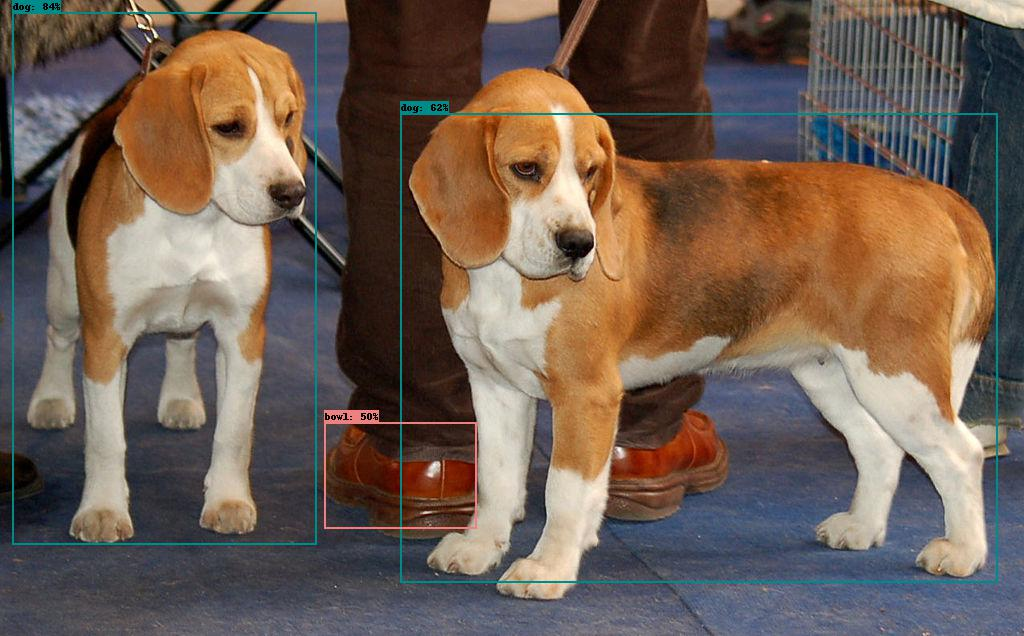

In [7]:
from IPython import display
display.display(display.Image(os.path.join(serve_image_out, '0.jpg')))

mkdir: cannot create directory ‘serve_image_out’: File exists
2021-02-25 15:45:10.403484: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-02-25 15:45:15.982906: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-02-25 15:45:15.983509: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-02-25 15:45:15.984539: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-02-25 15:45:16.002376: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: TITAN X (Pascal) computeCa

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W0225 15:45:58.868099 140254686578496 deprecation.py:339] From /shared/anastasio-s1/Cellcounting/wb_cells/cell_detection/efficientdet/inference.py:558: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
W0225 15:45:58.868506 140254686578496 deprecation.py:339] From /home/sh38/anaconda3/envs/tf_effdet/lib/python3.6/site-packages/tensorflow/python/framework/convert_to_constants.py:856: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2021-02-25 15:46:03.188733: I tensorflow/stream_executor/platform/default/dso

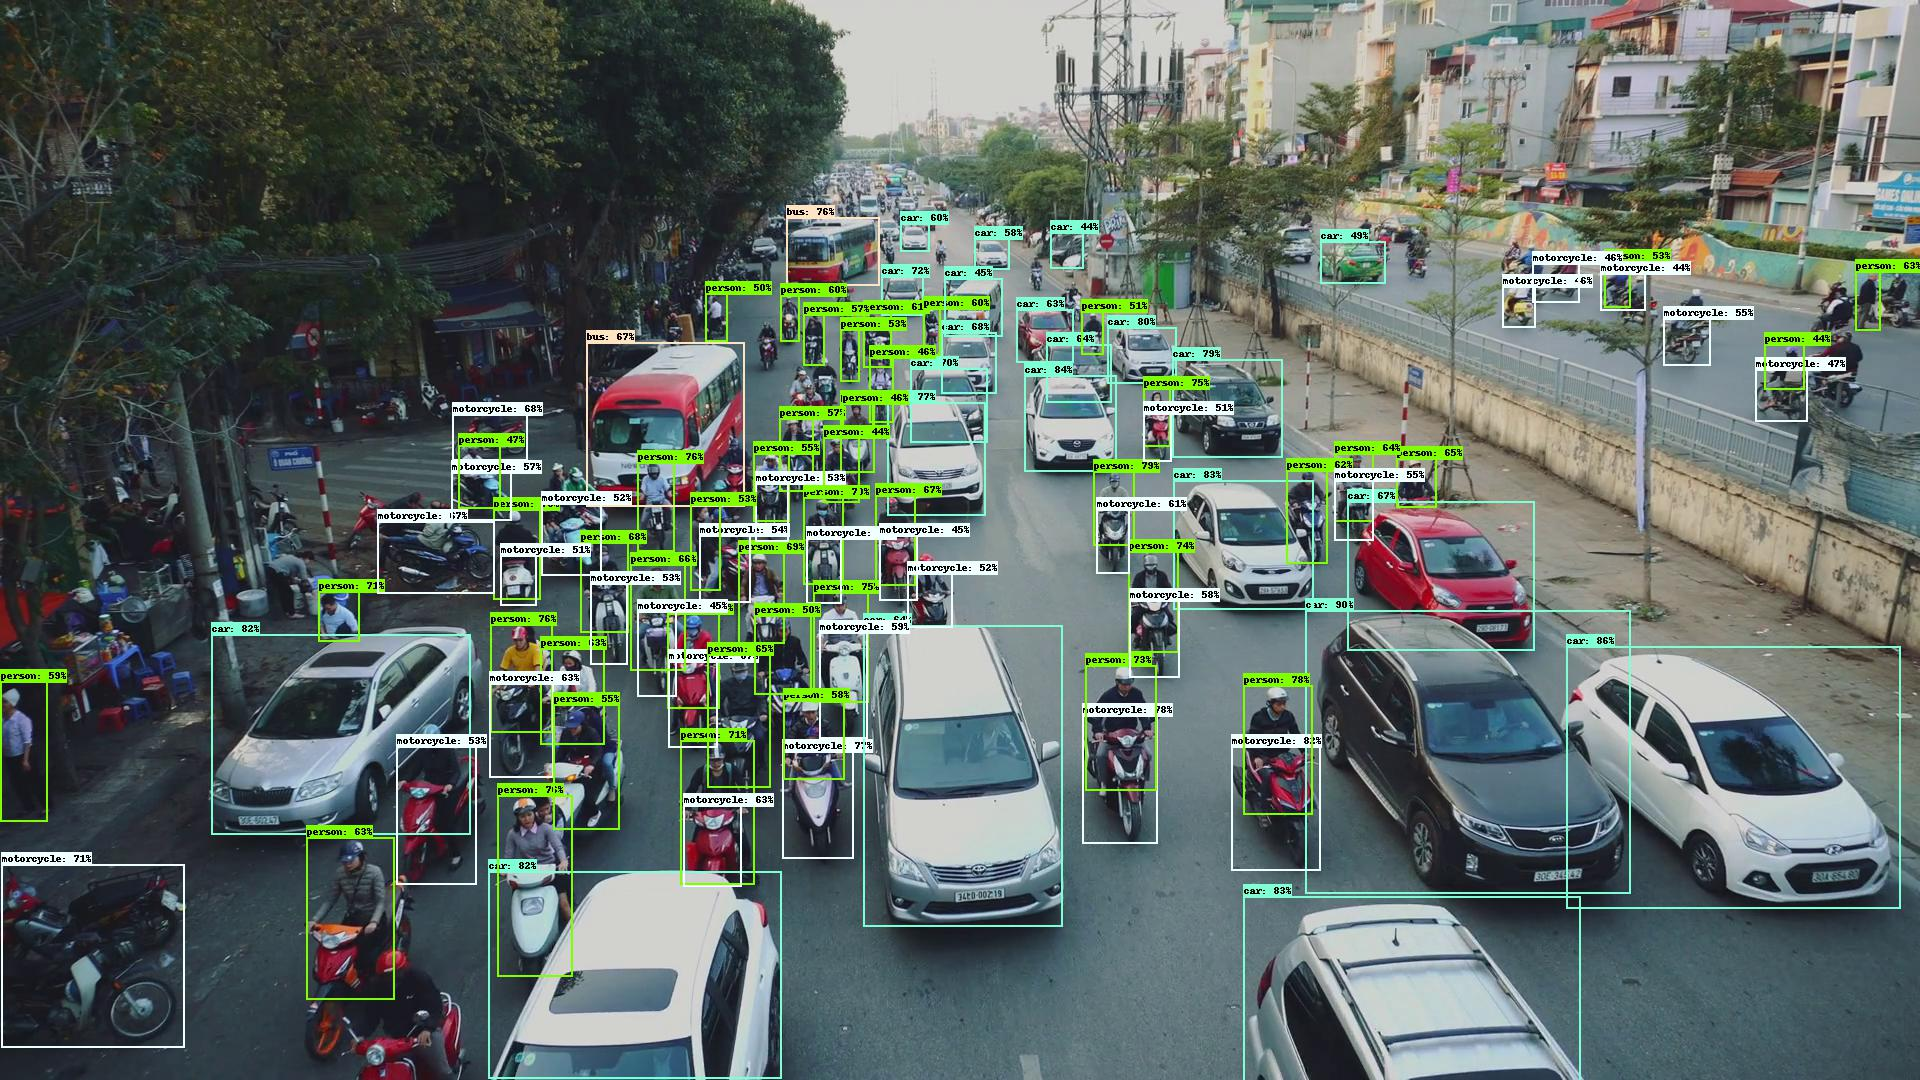

In [8]:
# In case you need to specify different image size or batch size or #boxes, then
# you need to export a new saved model and run the inferernce.

serve_image_out = 'serve_image_out'
!mkdir {serve_image_out}
saved_model_dir = 'savedmodel'
!rm -rf {saved_model_dir}

# Step 1: export model
!python model_inspect.py --runmode=saved_model \
  --model_name=efficientdet-d0 --ckpt_path=efficientdet-d0 \
  --hparams="image_size=1920x1280" --saved_model_dir={saved_model_dir}

# Step 2: do inference with saved model.
!python model_inspect.py --runmode=saved_model_infer \
  --model_name=efficientdet-d0 --saved_model_dir={saved_model_dir} \
  --input_image=img.png --output_image_dir={serve_image_out} \
  --min_score_thresh={min_score_thresh}  --max_boxes_to_draw={max_boxes_to_draw}

from IPython import display
display.display(display.Image(os.path.join(serve_image_out, '0.jpg')))

## 1.4 Inference video

In [9]:
# step 0: download video
video_url = 'https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/data/video480p.mov'  # @param
!wget {video_url} -O input.mov

# Step 1: export model
saved_model_dir = 'savedmodel'
!rm -rf {saved_model_dir}

!python model_inspect.py --runmode=saved_model \
  --model_name=efficientdet-d0 --ckpt_path=efficientdet-d0 \
  --saved_model_dir={saved_model_dir} --hparams="mixed_precision=true"

# Step 2: do inference with saved model using saved_model_video
!python model_inspect.py --runmode=saved_model_video \
  --model_name=efficientdet-d0   --ckpt_path=efficientdet-d0 \
  --saved_model_dir={saved_model_dir} --hparams="mixed_precision=true" \
  --input_video=input.mov --output_video=output.mov
# Then you can view the output.mov

--2021-02-25 15:46:22--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/data/video480p.mov
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.4.80, 172.217.9.80, 172.217.1.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.4.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18511760 (18M) [application/octet-stream]
Saving to: ‘input.mov’

100%[======================================>] 18,511,760  40.7MB/s   in 0.4s   

2021-02-25 15:46:22 (40.7 MB/s) - ‘input.mov’ saved [18511760/18511760]

2021-02-25 15:46:23.969073: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-02-25 15:46:29.766714: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in 

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W0225 15:47:12.967050 139818531354432 deprecation.py:339] From /shared/anastasio-s1/Cellcounting/wb_cells/cell_detection/efficientdet/inference.py:558: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
W0225 15:47:12.967322 139818531354432 deprecation.py:339] From /home/sh38/anaconda3/envs/tf_effdet/lib/python3.6/site-packages/tensorflow/python/framework/convert_to_constants.py:856: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2021-02-25 15:47:16.643932: I tensorflow/stream_executor/platform/default/dso

# 3. COCO evaluation

## 3.1 COCO evaluation on validation set.

In [3]:
if 'val2017' not in os.listdir():
  !wget http://images.cocodataset.org/zips/val2017.zip
  !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
  !unzip -q val2017.zip
  !unzip annotations_trainval2017.zip

  !mkdir tfrecord
  !PYTHONPATH=".:$PYTHONPATH"  python dataset/create_coco_tfrecord.py \
      --image_dir=val2017 \
      --caption_annotations_file=annotations/captions_val2017.json \
      --output_file_prefix=tfrecord/val \
      --num_shards=32

In [6]:
# Evalute on validation set (takes about 10 mins for efficientdet-d0)
!python main.py --mode=eval  \
    --model_name={MODEL}  --model_dir={ckpt_path}  \
    --val_file_pattern=tfrecord/val*  \
    --val_json_file=annotations/instances_val2017.json

2021-02-26 00:39:32.966169: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
I0226 00:39:40.136761 140691455612736 main.py:264] {'name': 'efficientdet-d0', 'act_type': 'swish', 'image_size': (512, 512), 'target_size': None, 'input_rand_hflip': True, 'jitter_min': 0.1, 'jitter_max': 2.0, 'autoaugment_policy': None, 'grid_mask': False, 'sample_image': None, 'map_freq': 5, 'num_classes': 90, 'seg_num_classes': 3, 'heads': ['object_detection'], 'skip_crowd_during_training': True, 'label_map': None, 'max_instances_per_image': 100, 'regenerate_source_id': False, 'min_level': 3, 'max_level': 7, 'num_scales': 3, 'aspect_ratios': [1.0, 2.0, 0.5], 'anchor_scale': 4.0, 'is_training_bn': True, 'momentum': 0.9, 'optimizer': 'sgd', 'learning_rate': 0.08, 'lr_warmup_init': 0.008, 'lr_warmup_epoch': 1.0, 'first_lr_drop_epoch': 200.0, 'second_lr_drop_epoch': 250.0, 'poly_lr_power': 0.9, 'clip_gradients_norm': 10.0, 'num_epochs': 300, 

INFO:tensorflow:Calling model_fn.
I0226 00:39:41.386786 140691455612736 estimator.py:1162] Calling model_fn.
I0226 00:39:41.394293 140691455612736 efficientnet_builder.py:215] global_params= GlobalParams(batch_norm_momentum=0.99, batch_norm_epsilon=0.001, dropout_rate=0.2, data_format='channels_last', num_classes=1000, width_coefficient=1.0, depth_coefficient=1.0, depth_divisor=8, min_depth=None, survival_prob=0.0, relu_fn=functools.partial(<function activation_fn at 0x7ff48de8dea0>, act_type='swish'), batch_norm=<class 'utils.BatchNormalization'>, use_se=True, local_pooling=None, condconv_num_experts=None, clip_projection_output=False, blocks_args=['r1_k3_s11_e1_i32_o16_se0.25', 'r2_k3_s22_e6_i16_o24_se0.25', 'r2_k5_s22_e6_i24_o40_se0.25', 'r3_k3_s22_e6_i40_o80_se0.25', 'r3_k5_s11_e6_i80_o112_se0.25', 'r4_k5_s22_e6_i112_o192_se0.25', 'r1_k3_s11_e6_i192_o320_se0.25'], fix_head_stem=None, grad_checkpoint=False)
I0226 00:39:41.654167 140691455612736 efficientdet_keras.py:749] fnode 0 : {

I0226 00:39:42.572758 140691455612736 efficientnet_model.py:390] Expand shape: (1, 32, 32, 672)
I0226 00:39:42.603206 140691455612736 efficientnet_model.py:393] DWConv shape: (1, 32, 32, 672)
I0226 00:39:42.623636 140691455612736 efficientnet_model.py:195] Built SE se : (1, 1, 1, 672)
I0226 00:39:42.642641 140691455612736 efficientnet_model.py:414] Project shape: (1, 32, 32, 112)
I0226 00:39:42.643235 140691455612736 efficientnet_model.py:374] Block blocks_10 input shape: (1, 32, 32, 112)
I0226 00:39:42.663813 140691455612736 efficientnet_model.py:390] Expand shape: (1, 32, 32, 672)
I0226 00:39:42.683989 140691455612736 efficientnet_model.py:393] DWConv shape: (1, 32, 32, 672)
I0226 00:39:42.704159 140691455612736 efficientnet_model.py:195] Built SE se : (1, 1, 1, 672)
I0226 00:39:42.722929 140691455612736 efficientnet_model.py:414] Project shape: (1, 32, 32, 112)
I0226 00:39:42.723531 140691455612736 efficientnet_model.py:374] Block blocks_11 input shape: (1, 32, 32, 112)
I0226 00:39:

2021-02-26 00:39:50.188814: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
INFO:tensorflow:Evaluation [500/5000]
I0226 00:40:51.275236 140691455612736 evaluation.py:167] Evaluation [500/5000]
INFO:tensorflow:Evaluation [1000/5000]
I0226 00:41:49.823111 140691455612736 evaluation.py:167] Evaluation [1000/5000]
INFO:tensorflow:Evaluation [1500/5000]
I0226 00:42:49.259710 140691455612736 evaluation.py:167] Evaluation [1500/5000]
INFO:tensorflow:Evaluation [2000/5000]
I0226 00:43:53.128959 140691455612736 evaluation.py:167] Evaluation [2000/5000]
INFO:tensorflow:Evaluation [2500/5000]
I0226 00:44:59.864163 140691455612736 evaluation.py:167] Evaluation [2500/5000]
INFO:tensorflow:Evaluation [3000/5000]
I0226 00:46:00.575294 140691455612736 evaluation.py:167] Evaluation [3000/5000]
INFO:tensorflow:Evaluation [3500/5000]
I0226 00:47:00.654020 140691455612736 evaluation.py:167] Evaluation [3500/5000]
INFO:tensorfl

## 3.2 COCO evaluation on test-dev.

In [ ]:
# Eval on test-dev is slow (~40 mins), please be cautious. 
RUN_EXPENSIVE_TEST_DEV_EVAL = True  #@param

if RUN_EXPENSIVE_TEST_DEV_EVAL == True:
  !rm *.zip *.tar tfrecord/ val2017/   # Cleanup disk space
  # Download and convert test-dev data.
  if "test2017" not in os.listdir():
    !wget http://images.cocodataset.org/zips/test2017.zip
    !unzip -q test2017.zip
    !wget http://images.cocodataset.org/annotations/image_info_test2017.zip
    !unzip image_info_test2017.zip

    !mkdir tfrecord
    !PYTHONPATH=".:$PYTHONPATH"  python dataset/create_coco_tfrecord.py \
          --image_dir=test2017 \
          --image_info_file=annotations/image_info_test-dev2017.json \
          --output_file_prefix=tfrecord/testdev \
          --num_shards=32

  # Evalute on validation set: non-empty testdev_dir is the key pararmeter.
  # Also, test-dev has 20288 images rather than val 5000 images.
  !mkdir testdev_output
  !python main.py --mode=eval  \
      --model_name={MODEL}  --model_dir={ckpt_path}  \
      --val_file_pattern=tfrecord/testdev*  \
      --eval_batch_size=8  --eval_samples=20288 \
      --testdev_dir='testdev_output'
  !rm -rf test2017  # delete images to release disk space.
  # Now you can submit testdev_output/detections_test-dev2017_test_results.json to
  # coco server: https://competitions.codalab.org/competitions/20794#participate

rm: cannot remove ‘tfrecord/’: Is a directory
rm: cannot remove ‘val2017/’: Is a directory
--2021-02-25 16:11:26--  http://images.cocodataset.org/zips/test2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.36.172
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.36.172|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6646970404 (6.2G) [application/zip]
Saving to: ‘test2017.zip’

100%[====================================>] 6,646,970,404 56.8MB/s   in 3m 46s 

2021-02-25 16:15:22 (28.0 MB/s) - ‘test2017.zip’ saved [6646970404/6646970404]

--2021-02-25 16:20:16--  http://images.cocodataset.org/annotations/image_info_test2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.128.163
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.128.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1144034 (1.1M) [application/zip]
Saving to: ‘image_info_test2017.zip’



# 4. Training EfficientDets on PASCAL.

## 4.1 Prepare data

In [7]:
# Get pascal voc 2012 trainval data
import os
if 'VOCdevkit' not in os.listdir():
  !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
  !tar xf VOCtrainval_11-May-2012.tar

  !mkdir tfrecord
  !PYTHONPATH=".:$PYTHONPATH"  python dataset/create_pascal_tfrecord.py  \
    --data_dir=VOCdevkit --year=VOC2012  --output_path=tfrecord/pascal

# Pascal has 5717 train images with 100 shards epoch, here we use a single shard
# for demo, but users should use all shards pascal-*-of-00100.tfrecord.
file_pattern = 'pascal-00000-of-00100.tfrecord'  # @param
images_per_epoch = 57 * len(tf.io.gfile.glob('tfrecord/' + file_pattern))
images_per_epoch = images_per_epoch // 8 * 8  # round to 64.
print('images_per_epoch = {}'.format(images_per_epoch))

images_per_epoch = 56


## 4.2 Train Pascal VOC 2012 from ImageNet checkpoint for Backbone.

In [8]:
# Train efficientdet from scratch with backbone checkpoint.
backbone_name = {
    'efficientdet-d0': 'efficientnet-b0',
    'efficientdet-d1': 'efficientnet-b1',
    'efficientdet-d2': 'efficientnet-b2',
    'efficientdet-d3': 'efficientnet-b3',
    'efficientdet-d4': 'efficientnet-b4',
    'efficientdet-d5': 'efficientnet-b5',
    'efficientdet-d6': 'efficientnet-b6',
    'efficientdet-d7': 'efficientnet-b6',
}[MODEL]


# generating train tfrecord is large, so we skip the execution here.
import os
if backbone_name not in os.listdir():
  !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/ckptsaug/{backbone_name}.tar.gz
  !tar xf {backbone_name}.tar.gz

!mkdir /tmp/model_dir
# key option: use --backbone_ckpt rather than --ckpt.
# Don't use ema since we only train a few steps.
!python main.py --mode=train_and_eval \
    --train_file_pattern=tfrecord/{file_pattern} \
    --val_file_pattern=tfrecord/{file_pattern} \
    --model_name={MODEL} \
    --model_dir=/tmp/model_dir/{MODEL}-scratch  \
    --backbone_ckpt={backbone_name} \
    --train_batch_size=4 \
    --eval_batch_size=4 --eval_samples={images_per_epoch}  \
    --num_examples_per_epoch={images_per_epoch}  --num_epochs=1  \
    --hparams="num_classes=20,moving_average_decay=0,mixed_precision=true"

--2021-02-26 00:56:07--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/ckptsaug/efficientnet-b0.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.4.48, 216.58.192.176, 172.217.4.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.4.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39302973 (37M) [application/gzip]
Saving to: ‘efficientnet-b0.tar.gz’

100%[======================================>] 39,302,973  25.3MB/s   in 1.5s   

2021-02-26 00:56:09 (25.3 MB/s) - ‘efficientnet-b0.tar.gz’ saved [39302973/39302973]

2021-02-26 00:56:12.353765: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
I0226 00:56:20.767615 140685562124096 main.py:264] {'name': 'efficientdet-d0', 'act_type': 'swish', 'image_size': (512, 512), 'target_size': None, 'input_rand_hflip': True, 'jitter_min': 0.1, 'jitter_max': 2.0, 'autoaugment_policy': No

I0226 00:56:21.349623 140685562124096 dataloader.py:92] target_size = (512, 512), output_size = (512, 512)
INFO:tensorflow:Calling model_fn.
I0226 00:56:21.729260 140685562124096 estimator.py:1162] Calling model_fn.
W0226 00:56:21.729467 140685562124096 utils.py:557] float16 is not supported for CPU, use float32 instead
I0226 00:56:21.735879 140685562124096 efficientnet_builder.py:215] global_params= GlobalParams(batch_norm_momentum=0.99, batch_norm_epsilon=0.001, dropout_rate=0.2, data_format='channels_last', num_classes=1000, width_coefficient=1.0, depth_coefficient=1.0, depth_divisor=8, min_depth=None, survival_prob=0.0, relu_fn=functools.partial(<function activation_fn at 0x7ff32ea18ea0>, act_type='swish'), batch_norm=<class 'utils.BatchNormalization'>, use_se=True, local_pooling=None, condconv_num_experts=None, clip_projection_output=False, blocks_args=['r1_k3_s11_e1_i32_o16_se0.25', 'r2_k3_s22_e6_i16_o24_se0.25', 'r2_k5_s22_e6_i24_o40_se0.25', 'r3_k3_s22_e6_i40_o80_se0.25', 'r3_k

I0226 00:56:22.996381 140685562124096 efficientnet_model.py:414] Project shape: (4, 32, 32, 112)
I0226 00:56:22.996835 140685562124096 efficientnet_model.py:374] Block blocks_9 input shape: (4, 32, 32, 112)
I0226 00:56:23.021283 140685562124096 efficientnet_model.py:390] Expand shape: (4, 32, 32, 672)
I0226 00:56:23.046103 140685562124096 efficientnet_model.py:393] DWConv shape: (4, 32, 32, 672)
I0226 00:56:23.065192 140685562124096 efficientnet_model.py:195] Built SE se : (4, 1, 1, 672)
I0226 00:56:23.088728 140685562124096 efficientnet_model.py:414] Project shape: (4, 32, 32, 112)
I0226 00:56:23.089204 140685562124096 efficientnet_model.py:374] Block blocks_10 input shape: (4, 32, 32, 112)
I0226 00:56:23.113468 140685562124096 efficientnet_model.py:390] Expand shape: (4, 32, 32, 672)
I0226 00:56:23.138363 140685562124096 efficientnet_model.py:393] DWConv shape: (4, 32, 32, 672)
I0226 00:56:23.157556 140685562124096 efficientnet_model.py:195] Built SE se : (4, 1, 1, 672)
I0226 00:56:2

2021-02-26 00:56:39.249282: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-02-26 00:56:39.249322: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      0 
2021-02-26 00:56:39.249334: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 0:   N 
2021-02-26 00:56:39.532458: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2021-02-26 00:56:39.950837: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz
INFO:tensorflow:Running local_init_op.
I0226 00:56:42.358975 140685562124096 session_manager.py:505] Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I0226 00:56:42.537215 140685562124096 session_manager.py:508] Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
I0226 00:56:52.262164 140685562124096 basic_session_r

I0226 00:57:37.817593 140685562124096 efficientnet_model.py:414] Project shape: (4, 128, 128, 24)
I0226 00:57:37.818072 140685562124096 efficientnet_model.py:374] Block blocks_3 input shape: (4, 128, 128, 24)
I0226 00:57:37.836079 140685562124096 efficientnet_model.py:390] Expand shape: (4, 128, 128, 144)
I0226 00:57:37.854863 140685562124096 efficientnet_model.py:393] DWConv shape: (4, 64, 64, 144)
I0226 00:57:37.873448 140685562124096 efficientnet_model.py:195] Built SE se : (4, 1, 1, 144)
I0226 00:57:37.890974 140685562124096 efficientnet_model.py:414] Project shape: (4, 64, 64, 40)
I0226 00:57:37.891399 140685562124096 efficientnet_model.py:374] Block blocks_4 input shape: (4, 64, 64, 40)
I0226 00:57:37.909485 140685562124096 efficientnet_model.py:390] Expand shape: (4, 64, 64, 240)
I0226 00:57:37.928292 140685562124096 efficientnet_model.py:393] DWConv shape: (4, 64, 64, 240)
I0226 00:57:37.947047 140685562124096 efficientnet_model.py:195] Built SE se : (4, 1, 1, 240)
I0226 00:57:

INFO:tensorflow:Running local_init_op.
I0226 00:57:43.839214 140685562124096 session_manager.py:505] Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I0226 00:57:43.907166 140685562124096 session_manager.py:508] Done running local_init_op.
INFO:tensorflow:Evaluation [1/14]
I0226 00:57:46.984491 140685562124096 evaluation.py:167] Evaluation [1/14]
INFO:tensorflow:Evaluation [2/14]
I0226 00:57:47.293530 140685562124096 evaluation.py:167] Evaluation [2/14]
INFO:tensorflow:Evaluation [3/14]
I0226 00:57:47.607269 140685562124096 evaluation.py:167] Evaluation [3/14]
INFO:tensorflow:Evaluation [4/14]
I0226 00:57:47.921489 140685562124096 evaluation.py:167] Evaluation [4/14]
INFO:tensorflow:Evaluation [5/14]
I0226 00:57:48.236697 140685562124096 evaluation.py:167] Evaluation [5/14]
INFO:tensorflow:Evaluation [6/14]
I0226 00:57:48.547997 140685562124096 evaluation.py:167] Evaluation [6/14]
INFO:tensorflow:Evaluation [7/14]
I0226 00:57:48.868162 140685562124096 evaluation.py:16

## 4.3 Train Pascal VOC 2012 from COCO checkpoint for the whole net.

In [9]:
# generating train tfrecord is large, so we skip the execution here.
import os
if MODEL not in os.listdir():
  !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{MODEL}.tar.gz
  !tar xf {MODEL}.tar.gz

!mkdir /tmp/model_dir/
# key option: use --ckpt rather than --backbone_ckpt.
!python main.py --mode=train_and_eval \
    --train_file_pattern=tfrecord/{file_pattern} \
    --val_file_pattern=tfrecord/{file_pattern} \
    --model_name={MODEL} \
    --model_dir=/tmp/model_dir/{MODEL}-finetune \
    --ckpt={MODEL} \
    --train_batch_size=8 \
    --eval_batch_size=8 --eval_samples={images_per_epoch}  \
    --num_examples_per_epoch={images_per_epoch}  --num_epochs=1  \
    --hparams="num_classes=20,moving_average_decay=0,mixed_precision=true"

mkdir: cannot create directory ‘/tmp/model_dir/’: File exists
2021-02-26 01:00:47.776862: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
I0226 01:00:54.138932 139693199882048 main.py:264] {'name': 'efficientdet-d0', 'act_type': 'swish', 'image_size': (512, 512), 'target_size': None, 'input_rand_hflip': True, 'jitter_min': 0.1, 'jitter_max': 2.0, 'autoaugment_policy': None, 'grid_mask': False, 'sample_image': None, 'map_freq': 5, 'num_classes': 20, 'seg_num_classes': 3, 'heads': ['object_detection'], 'skip_crowd_during_training': True, 'label_map': None, 'max_instances_per_image': 100, 'regenerate_source_id': False, 'min_level': 3, 'max_level': 7, 'num_scales': 3, 'aspect_ratios': [1.0, 2.0, 0.5], 'anchor_scale': 4.0, 'is_training_bn': True, 'momentum': 0.9, 'optimizer': 'sgd', 'learning_rate': 0.08, 'lr_warmup_init': 0.008, 'lr_warmup_epoch': 1.0, 'first_lr_drop_epoch': 200.0, 'second_lr_drop_epoch': 250.0, 'poly_lr

2021-02-26 01:00:54.365431: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/cuda-11.1/lib64:/software/gcc-7.2.0/lib64:/software/gcc-7.2.0/lib:/software/mpich-3.2.1-gcc7.2.0/lib:/software/openmpi-4.0.1-gcc-4.8.5/lib:/software/cuda-11.1/extras/CUPTI/lib64
2021-02-26 01:00:54.365449: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1757] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
I0226 01:00:54.549001 139693199882048 dataloader.py:92] target_size = (512, 512), output_size = (512, 512)
INFO:tensorflow:Calling model_fn.
I0226 01:00:54.880427 139693199882048

I0226 01:00:55.911558 139693199882048 efficientnet_model.py:390] Expand shape: (8, 32, 32, 480)
I0226 01:00:55.936115 139693199882048 efficientnet_model.py:393] DWConv shape: (8, 32, 32, 480)
I0226 01:00:55.954600 139693199882048 efficientnet_model.py:195] Built SE se : (8, 1, 1, 480)
I0226 01:00:55.977450 139693199882048 efficientnet_model.py:414] Project shape: (8, 32, 32, 80)
I0226 01:00:55.977901 139693199882048 efficientnet_model.py:374] Block blocks_8 input shape: (8, 32, 32, 80)
I0226 01:00:56.001225 139693199882048 efficientnet_model.py:390] Expand shape: (8, 32, 32, 480)
I0226 01:00:56.025195 139693199882048 efficientnet_model.py:393] DWConv shape: (8, 32, 32, 480)
I0226 01:00:56.044114 139693199882048 efficientnet_model.py:195] Built SE se : (8, 1, 1, 480)
I0226 01:00:56.066629 139693199882048 efficientnet_model.py:414] Project shape: (8, 32, 32, 112)
I0226 01:00:56.067073 139693199882048 efficientnet_model.py:374] Block blocks_9 input shape: (8, 32, 32, 112)
I0226 01:00:56.0

2021-02-26 01:01:12.736238: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-02-26 01:01:12.736311: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      0 
2021-02-26 01:01:12.736337: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 0:   N 
2021-02-26 01:01:13.091064: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2021-02-26 01:01:13.594760: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz
INFO:tensorflow:Running local_init_op.
I0226 01:01:16.264171 139693199882048 session_manager.py:505] Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I0226 01:01:16.452760 139693199882048 session_manager.py:508] Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
I0226 01:01:26.544881 139693199882048 basic_session_r

I0226 01:02:12.062052 139693199882048 efficientnet_model.py:414] Project shape: (8, 128, 128, 24)
I0226 01:02:12.062530 139693199882048 efficientnet_model.py:374] Block blocks_3 input shape: (8, 128, 128, 24)
I0226 01:02:12.081088 139693199882048 efficientnet_model.py:390] Expand shape: (8, 128, 128, 144)
I0226 01:02:12.099724 139693199882048 efficientnet_model.py:393] DWConv shape: (8, 64, 64, 144)
I0226 01:02:12.118221 139693199882048 efficientnet_model.py:195] Built SE se : (8, 1, 1, 144)
I0226 01:02:12.135660 139693199882048 efficientnet_model.py:414] Project shape: (8, 64, 64, 40)
I0226 01:02:12.136085 139693199882048 efficientnet_model.py:374] Block blocks_4 input shape: (8, 64, 64, 40)
I0226 01:02:12.154085 139693199882048 efficientnet_model.py:390] Expand shape: (8, 64, 64, 240)
I0226 01:02:12.172761 139693199882048 efficientnet_model.py:393] DWConv shape: (8, 64, 64, 240)
I0226 01:02:12.191380 139693199882048 efficientnet_model.py:195] Built SE se : (8, 1, 1, 240)
I0226 01:02:

INFO:tensorflow:Running local_init_op.
I0226 01:02:18.445799 139693199882048 session_manager.py:505] Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I0226 01:02:18.562787 139693199882048 session_manager.py:508] Done running local_init_op.
INFO:tensorflow:Evaluation [1/7]
I0226 01:02:22.683588 139693199882048 evaluation.py:167] Evaluation [1/7]
INFO:tensorflow:Evaluation [2/7]
I0226 01:02:23.327334 139693199882048 evaluation.py:167] Evaluation [2/7]
INFO:tensorflow:Evaluation [3/7]
I0226 01:02:23.985481 139693199882048 evaluation.py:167] Evaluation [3/7]
INFO:tensorflow:Evaluation [4/7]
I0226 01:02:24.636456 139693199882048 evaluation.py:167] Evaluation [4/7]
INFO:tensorflow:Evaluation [5/7]
I0226 01:02:25.289304 139693199882048 evaluation.py:167] Evaluation [5/7]
INFO:tensorflow:Evaluation [6/7]
I0226 01:02:25.941901 139693199882048 evaluation.py:167] Evaluation [6/7]
INFO:tensorflow:Evaluation [7/7]
I0226 01:02:26.589524 139693199882048 evaluation.py:167] Evaluation

## 4.4 View tensorboard for loss and accuracy.


In [ ]:
%load_ext tensorboard
%tensorboard --logdir /tmp/model_dir/
# Notably, this is just a demo with almost zero accuracy due to very limited
# training steps, but we can see finetuning has smaller loss than training
# from scratch at the begining.